In [1]:
# Install necessary libraries
!pip install pandas numpy scipy matplotlib prophet plotly

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from google.colab import files
from prophet import Prophet
from sklearn.metrics import mean_squared_error

In [3]:
# Upload dataset
uploaded = files.upload()

Saving Global EV Data 2024.csv to Global EV Data 2024.csv


In [4]:
# Load dataset
df = pd.read_csv('Global EV Data 2024.csv')

In [5]:
# Data cleaning: Drop missing values and convert year column to datetime
df.dropna(inplace=True)  # Menghapus baris dengan nilai yang hilang
df['year'] = pd.to_datetime(df['year'], format='%Y')  # Ubah kolom tahun menjadi format datetime

In [6]:
# Feature engineering: Calculate yearly growth
df['yearly_growth'] = df.groupby('region')['value'].pct_change() * 100  # Hitung pertumbuhan tahunan

In [7]:
# Outlier detection and removal
z_scores = np.abs(stats.zscore(df['value']))  # Hitung Z-score untuk deteksi outlier
df = df[(z_scores < 3)]  # Hapus data yang merupakan outlier

In [8]:
# Overview of the data
df.head()

,region,category,parameter,mode,powertrain,year,unit,value,yearly_growth
0,Australia,Historical,EV stock share,Cars,EV,2011-01-01,percent,0.00039,NaN
1,Australia,Historical,EV sales share,Cars,EV,2011-01-01,percent,0.00650,1566.666697
2,Australia,Historical,EV sales,Cars,BEV,2011-01-01,Vehicles,49.00000,753746.138293
3,Australia,Historical,EV stock,Cars,BEV,2011-01-01,Vehicles,49.00000,0.000000
4,Australia,Historical,EV stock,Cars,BEV,2012-01-01,Vehicles,220.00000,348.979592


In [9]:
# Group data by region and year
region_growth = df.groupby(['region', 'year'])['value'].sum().reset_index()

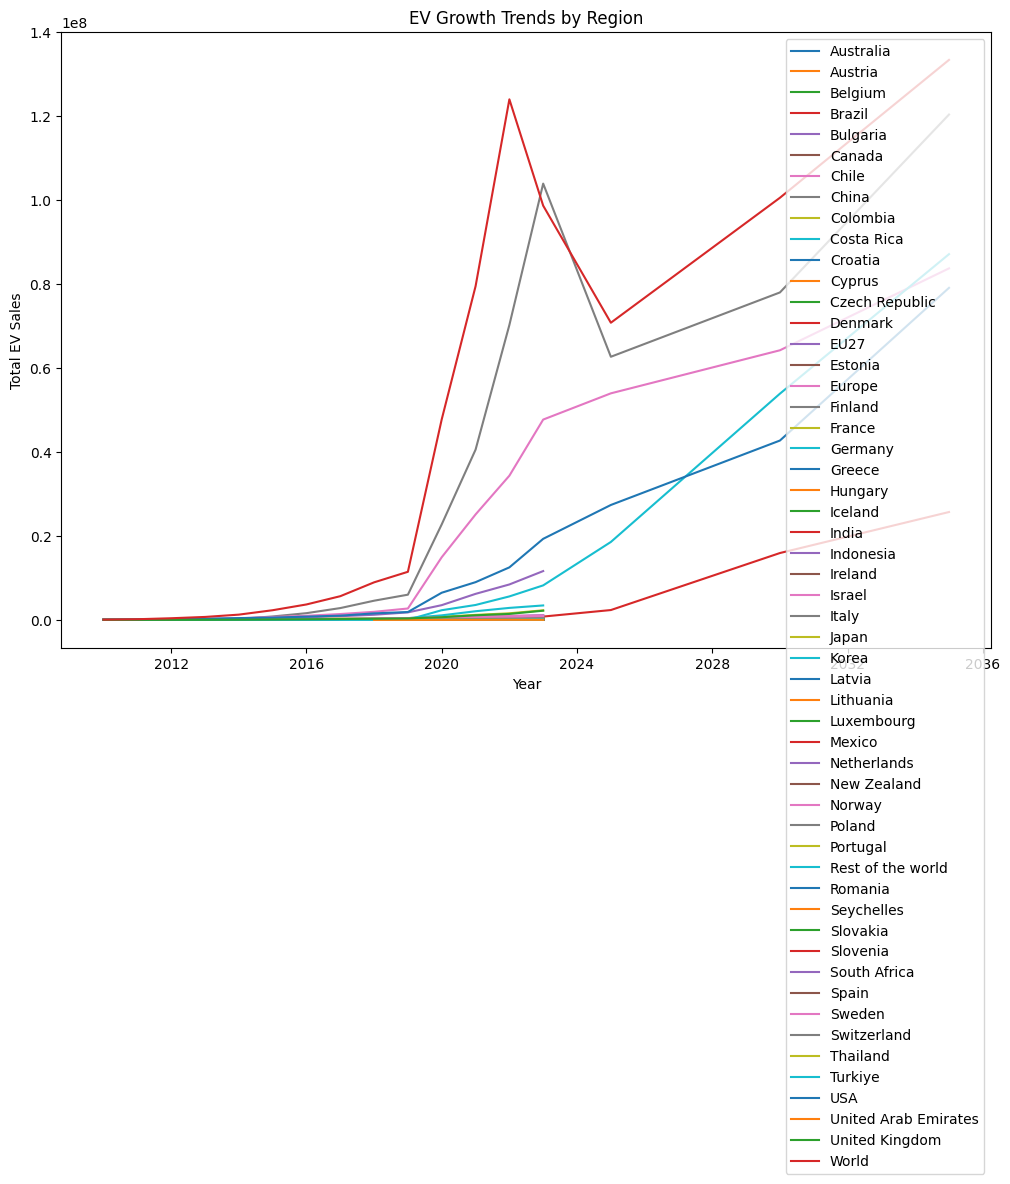

In [10]:
# Plotting trends for selected regions
plt.figure(figsize=(12, 8))
for region in region_growth['region'].unique():
    subset = region_growth[region_growth['region'] == region]
    plt.plot(subset['year'], subset['value'], label=region)

plt.title('EV Growth Trends by Region')
plt.xlabel('Year')
plt.ylabel('Total EV Sales')
plt.legend()
plt.show()

In [11]:
# Prepare data for Prophet model
df_prophet = region_growth[region_growth['region'] == 'Europe'][['year', 'value']].rename(columns={'year': 'ds', 'value': 'y'})

In [12]:
# Instantiate and train Prophet model
model = Prophet()
model.fit(df_prophet)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu1nbaljl/x_f967z9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu1nbaljl/8k69ran3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54676', 'data', 'file=/tmp/tmpu1nbaljl/x_f967z9.json', 'init=/tmp/tmpu1nbaljl/8k69ran3.json', 'output', 'file=/tmp/tmpu1nbaljl/prophet_modelaozwvfsm/prophet_model-20240813043335.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
04:33:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:33:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:

In [13]:
# Forecasting the next 12 months
future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


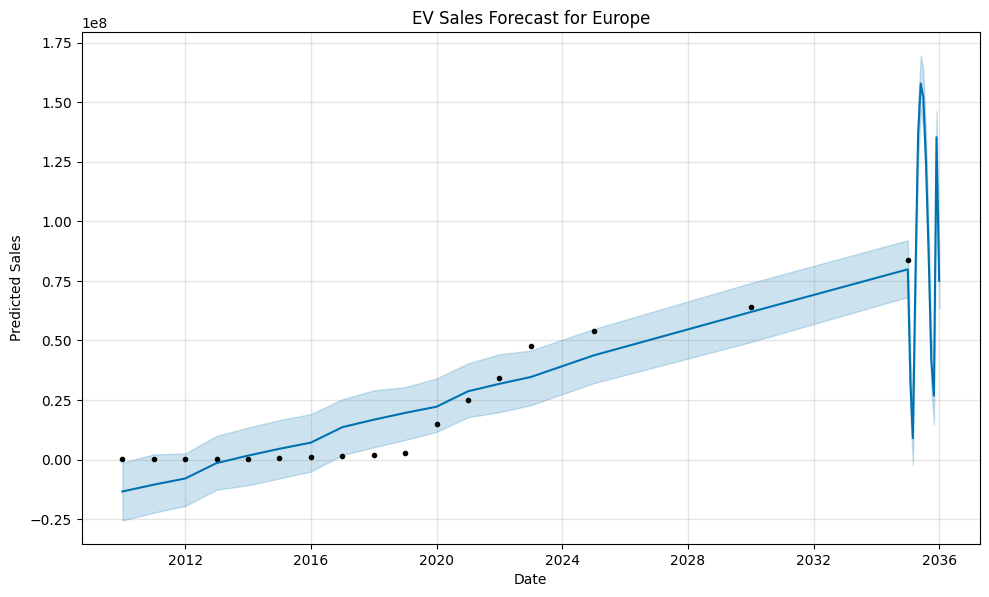

In [14]:
# Plot the forecast
model.plot(forecast)
plt.title('EV Sales Forecast for Europe')
plt.xlabel('Date')
plt.ylabel('Predicted Sales')
plt.show()

In [15]:
# Evaluate the model
y_true = df_prophet['y'].values
y_pred = forecast['yhat'].iloc[:len(y_true)].values
mse = mean_squared_error(y_true, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 84381659424415.77


/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` o

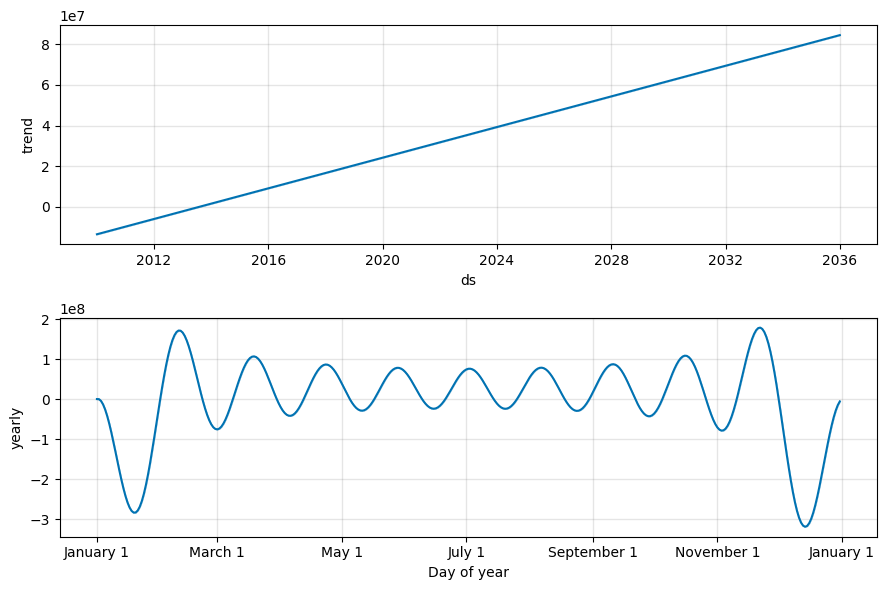

In [16]:
# Plot forecast components
model.plot_components(forecast)
plt.show()